<h1><center> "Hello, World!" FEniCS Style</center></h1>

<h3><center> FEniCS Workshop Exercise 1</center></h3>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

We will now proceed to the finite element equivalent of `print("Hello, World!")`: solving Poisson's equation!

\begin{equation}
  -\nabla^2u  = f \qquad \text{in} \,\,\, \Omega\,.
\end{equation}

To make our life simple, we will _manufacture_ a solution, by inserting the solution $u(x, y) = 1 + x^2 + 2y^2$, into the Poisson's equation, giving

\begin{equation}
f = -\nabla^2u = -\nabla^2(1 + x^2 + 2y^2) = -(2+4) = -6
\end{equation}
This is also the boundary condition of the problem.

In [2]:
from fenics import *

The first step is to define a mesh, in this case we will solve the Poisson's equation on a unit square mesh (try the function `UnitSquareMesh(ny, ny)`)

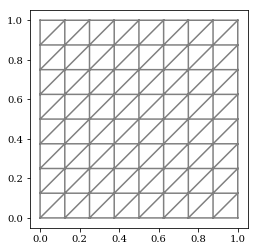

In [3]:
mesh = UnitSquareMesh(8, 8)# create an 8x8 unit square mesh
plot(mesh);

Now will define our function space. For this we can use the function `FunctionSpace(mesh, 'element', order)`. This function requires a mesh, a family of elements and an order as paramaters.

In [4]:
V = FunctionSpace(mesh, 'Lagrange', 1) # Use first order Lagrange elements, and the mesh you just created

We are now ready to set up the problem. We will define the value of $u$ on the boundary as

\begin{equation}
u_D = 1 + x^2 + 2y^2\,.
\end{equation}

(hint: try to define an `Expression()`)

In [5]:
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
#the expression is written C-style: 1 + x[0]*x[0] + 2*x[1]*x[1]

The boundary conditions of this problem are: $u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = u_D$. To impose this, we need a function that return `True` if the node lies on the boundary and `False` otherwise.

In [6]:
def boundary(x, on_boundary):
    # x[0] = x, x[1] = y
    return near(x[0], 0) or near(x[0], 1) or near(x[1], 0) or near(x[1], 1)

Now tell __FEniCS__ to apply the boundary condition on $V$ using the epxression $u_D$ on the boundary. `DirichletBC()`

In [7]:
bc = DirichletBC(V, u_D, boundary)

Now that we have our domain and boundary condition, we need to specify the test and trial function. For simplicity we will use the same function space for both.

In [8]:
# both trial and test functions are defined based on the same function space V
u = TrialFunction(V)
v = TestFunction(V)

The only part missing is the source term $f$, wich has a constant value of -6.

In [9]:
f = Constant(-6)
# can also be define as Expression("-6.0", degree=2) but this is less efficient

Now we must write the variational problem in the FEniCS form

\begin{equation}
    a(u, v) = L(v)\,,
\end{equation}

for our problem this gives

\begin{equation}
\begin{split}
    a(u, v) & = \int_{\Omega} (\nabla u \cdot\nabla v)\,\text{d}\Omega\,,\\
    L(v) & = \int_{\Omega} \,f \,v\,\text{d}\Omega\,.
\end{split}
\end{equation}

In [10]:
a = inner(grad(u), grad(v))*dx
L = f*v*dx

The only step left is to solve. For this, we first define a vector to store the solution $u_{sol}$, and set the solver parameters to the desired methods.

In [11]:
u_sol =  Function(V) # vector to store the solution
solve(a == L, u_sol, bc,
     solver_parameters={'linear_solver':'cg',
                        'preconditioner':'ilu'})

Plot the results

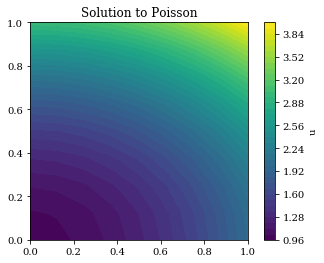

In [12]:
p = plot(u_sol, title="Solution to Poisson")
plt.colorbar(p, label="u");

---

__FEniCS__ has a function to compute the error in the L-2 norm. First we need an exact solution, because we manufactured a solution from a boundary condition, our boundary condition is also our exact solution. We can thus interpolate the boundary values into the domain using the space function $V$

In [13]:
u_e = interpolate(u_D, V)

Compute the $L_2$-norm of the error

In [14]:
error_L2 = errornorm(u_e, u_sol, 'L2')

In [15]:
print(f"L2 norm in the error {error_L2:.3e}")

L2 norm in the error 4.313e-16


---
It is also straight forward to extract values at any point in the domain

In [16]:
import numpy as np
tol = 0.001
y = np.linspace(0 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]
u_line = np.array([u_sol(point) for point in points])

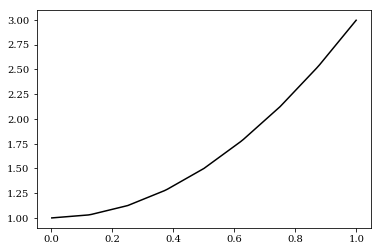

In [17]:
plt.plot(y, u_line, 'k');